In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

In [22]:
TRAIN_CSV = os.path.join('data', 'train.csv')
TEST_CSV = os.path.join('data', 'test.csv')

In [23]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Data insight and preparation

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [25]:
train_df.describe

<bound method NDFrame.describe of        id                       species   margin1   margin2   margin3  \
0       1                   Acer_Opalus  0.007812  0.023438  0.023438   
1       2         Pterocarya_Stenoptera  0.005859  0.000000  0.031250   
2       3          Quercus_Hartwissiana  0.005859  0.009766  0.019531   
3       5               Tilia_Tomentosa  0.000000  0.003906  0.023438   
4       6            Quercus_Variabilis  0.005859  0.003906  0.048828   
5       8          Magnolia_Salicifolia  0.070312  0.093750  0.033203   
6      10           Quercus_Canariensis  0.021484  0.031250  0.017578   
7      11                 Quercus_Rubra  0.000000  0.000000  0.037109   
8      14               Quercus_Brantii  0.005859  0.001953  0.033203   
9      15                Salix_Fragilis  0.000000  0.000000  0.009766   
10     17               Zelkova_Serrata  0.019531  0.031250  0.001953   
11     18         Betula_Austrosinensis  0.001953  0.001953  0.023438   
12     20        

In [26]:
train_df.dtypes

id             int64
species       object
margin1      float64
margin2      float64
margin3      float64
margin4      float64
margin5      float64
margin6      float64
margin7      float64
margin8      float64
margin9      float64
margin10     float64
margin11     float64
margin12     float64
margin13     float64
margin14     float64
margin15     float64
margin16     float64
margin17     float64
margin18     float64
margin19     float64
margin20     float64
margin21     float64
margin22     float64
margin23     float64
margin24     float64
margin25     float64
margin26     float64
margin27     float64
margin28     float64
              ...   
texture35    float64
texture36    float64
texture37    float64
texture38    float64
texture39    float64
texture40    float64
texture41    float64
texture42    float64
texture43    float64
texture44    float64
texture45    float64
texture46    float64
texture47    float64
texture48    float64
texture49    float64
texture50    float64
texture51    

In [27]:
train_df.groupby(['species'])['species'].count()

species
Acer_Capillipes                 10
Acer_Circinatum                 10
Acer_Mono                       10
Acer_Opalus                     10
Acer_Palmatum                   10
Acer_Pictum                     10
Acer_Platanoids                 10
Acer_Rubrum                     10
Acer_Rufinerve                  10
Acer_Saccharinum                10
Alnus_Cordata                   10
Alnus_Maximowiczii              10
Alnus_Rubra                     10
Alnus_Sieboldiana               10
Alnus_Viridis                   10
Arundinaria_Simonii             10
Betula_Austrosinensis           10
Betula_Pendula                  10
Callicarpa_Bodinieri            10
Castanea_Sativa                 10
Celtis_Koraiensis               10
Cercis_Siliquastrum             10
Cornus_Chinensis                10
Cornus_Controversa              10
Cornus_Macrophylla              10
Cotinus_Coggygria               10
Crataegus_Monogyna              10
Cytisus_Battandieri             10
Eucalyptus_G

## Summary
Data consists of 990 training examples described by 192 features, float64 type each. There are 99 classes, 10 examples per class. No imbalance, no invalid examples.

# Correlation

In [28]:
margins = train_df.filter(regex='^margin')
shapes = train_df.filter(regex='^shape')
textures = train_df.filter(regex='^texture')

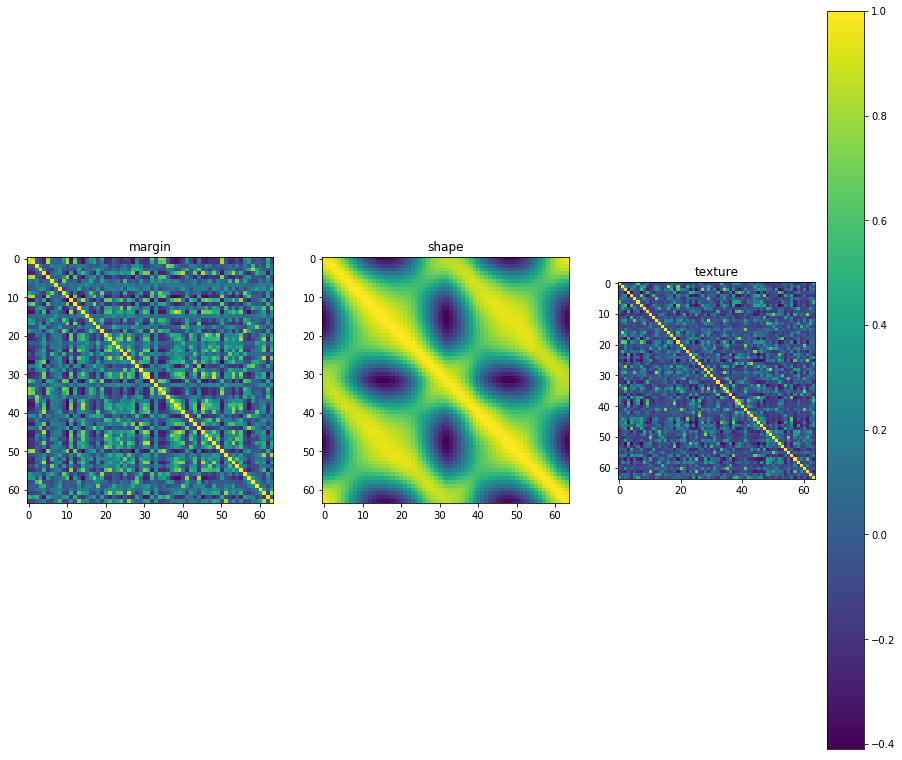

In [29]:
%matplotlib inline
margin_corr = margins.corr().values
shape_corr = shapes.corr().values
texture_corr = textures.corr().values

plt.figure(figsize=(15, 45))
plt.subplot(131)
plt.imshow(margin_corr)
plt.title('margin')
plt.subplot(132)
plt.imshow(shape_corr)
plt.title('shape')
plt.subplot(133)
plt.imshow(texture_corr)
plt.title('texture')
plt.colorbar()

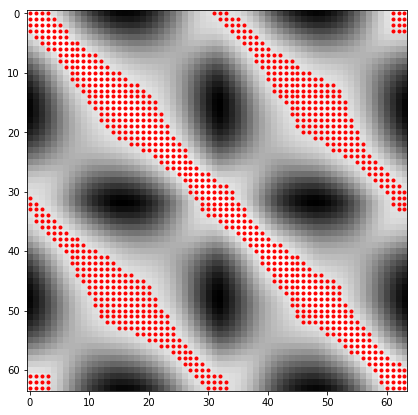

In [30]:
significant_corr = np.array([x > 0.9 for x in shape_corr])
scatter_coords = np.argwhere(significant_corr)
x = tuple([x[0] for x in scatter_coords])
y = tuple([x[1] for x in scatter_coords])
plt.figure(figsize=(7, 7))
plt.imshow(shape_corr, cmap='gray')
plt.scatter(x, y, color='r', marker='.')

(Red dots cover areas of correlation higher than 0.9)
## Summary
* No significant correlation for margin or texture
* Strong periodic correlation between different parts of shape vector. Blur suggests correlation for neighbouring values.

## Data preparation

In [31]:
X = train_df.drop(['id', 'species'], axis=1)
y = train_df.pop('species')

X_scaled = StandardScaler().fit(X).transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

# Classifiers Validation

In [32]:
logit = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
random_forest = ExtraTreesClassifier(n_estimators=500, random_state=0)
decission_tree = DecisionTreeClassifier(random_state=0)

logit_crossval = []
forest_crossval = []
tree_crossval = []

for train, test in skf.split(X_scaled, y):
    x_train = X_scaled[train]
    x_test = X_scaled[test]
    y_train = y[train]
    y_test = y[test]
    logit_crossval.append(logit.fit(x_train, y_train).score(x_test, y_test))
    forest_crossval.append(random_forest.fit(x_train, y_train).score(x_test, y_test))
    tree_crossval.append(decission_tree.fit(x_train, y_train).score(x_test, y_test))

In [33]:
print('Logistic Regression: {:.5f}{}{:.5f}'.format(np.mean(logit_crossval), u' \u00B1 ', np.std(logit_crossval)))
print('Decission Tree: {:.5f}{}{:.5f}'.format(np.mean(tree_crossval), u' \u00B1 ', np.std(tree_crossval)))
print('Random Forest: {:.5f}{}{:.5f}'.format(np.mean(forest_crossval), u' \u00B1 ', np.std(forest_crossval)))

Logistic Regression: 0.98889 ± 0.00378
Decission Tree: 0.66263 ± 0.02104
Random Forest: 0.98384 ± 0.01512


## Shape reduction

In [34]:
train_df = pd.read_csv(TRAIN_CSV)

cols = [c for c in train_df.filter(regex='^shape').columns if int(c.replace('shape', '')) > 32]
cols += ['id', 'species']
X = train_df.drop(cols, axis=1)

y = train_df.pop('species')
X_scaled = StandardScaler().fit(X).transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

logit = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
random_forest = ExtraTreesClassifier(n_estimators=500, random_state=0)
decission_tree = DecisionTreeClassifier(random_state=0)

reduced_logit_crossval = []
reduced_forest_crossval = []
reduced_tree_crossval = []

for train, test in skf.split(X_scaled, y):
    x_train = X_scaled[train]
    x_test = X_scaled[test]
    y_train = y[train]
    y_test = y[test]
    reduced_logit_crossval.append(logit.fit(x_train, y_train).score(x_test, y_test))
    reduced_forest_crossval.append(random_forest.fit(x_train, y_train).score(x_test, y_test))
    reduced_tree_crossval.append(decission_tree.fit(x_train, y_train).score(x_test, y_test))

In [35]:
print('Logistic Regression: {:.5f}{}{:.5f}'.format(np.mean(reduced_logit_crossval), u' \u00B1 ', np.std(reduced_logit_crossval)))
print('Decission Tree: {:.5f}{}{:.5f}'.format(np.mean(reduced_tree_crossval), u' \u00B1 ', np.std(reduced_tree_crossval)))
print('Random Forest: {:.5f}{}{:.5f}'.format(np.mean(reduced_forest_crossval), u' \u00B1 ', np.std(reduced_forest_crossval)))

Logistic Regression: 0.98889 ± 0.00378
Decission Tree: 0.66364 ± 0.02157
Random Forest: 0.98889 ± 0.01030


## Validation summary
* Logistic Regression and Random Forest classifiers perform very well in 5-fold cross validation. 
* Decission Tree achieves significantly worse results. Fine-tuning of the tree (setting max_depth or min_samples_leaf) does not lead to better results.
* Reducing shape feature does not cause classifiers to perform worse.